<a href="https://colab.research.google.com/github/himanshu230998/CS504-project/blob/main/Chaotic_system_double_pendulum_return_seq_true_sequence_length(200).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#import
from numpy import sin, cos
import numpy as np
import matplotlib.pyplot as plt
import scipy.integrate as integrate
import pickle
from itertools import *

import csv

import matplotlib.animation as animation
import random
import matplotlib.patches as mpatches
from statsmodels.tsa.arima_model import ARMA
from sklearn.metrics import r2_score
import pandas as pd
import tensorflow as tf


from pandas import read_csv
import math
from keras.models import Sequential
from keras.layers import Dense, Dropout, LeakyReLU
from keras.layers import LSTM
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [ ]:
G = 9.8  # acceleration due to gravity, in m/s^2
L1 = 1.0  # length of pendulum 1 in m
L2 = 1.0  # length of pendulum 2 in m
M1 = 1.0  # mass of pendulum 1 in kg
M2 = 2.0  # mass of pendulum 2 in kg

# derivs(state,t) returns array of 4 number [Z1, Z1_dot, Z2, Z2_dot]
def derivs(state, t):
    
    dydx = np.zeros_like(state)
    dydx[0] = state[1]

    del_ = state[2] - state[0]
    den1 = (M1 + M2)*L1 - M2*L1*cos(del_)*cos(del_) #del1=L1*(M1+M2*sin(del)*sin(del))
    dydx[1] = (M2*L1*state[1]*state[1]*sin(del_)*cos(del_) +
               M2*G*sin(state[2])*cos(del_) +
               M2*L2*state[3]*state[3]*sin(del_) -
               (M1 + M2)*G*sin(state[0]))/den1

    dydx[2] = state[3]

    den2 = (L2/L1)*den1
    dydx[3] = (-M2*L2*state[3]*state[3]*sin(del_)*cos(del_) +
               (M1 + M2)*G*sin(state[0])*cos(del_) -
               (M1 + M2)*L1*state[1]*state[1]*sin(del_) -
               (M1 + M2)*G*sin(state[2]))/den2

    return dydx

 
dt = 0.01
t = np.arange(0.0, 100 , dt)       #len(t)=9999
arr=[]
time=[]
state = np.radians([75, 0, 50, 0])
y = integrate.odeint(derivs, state, t)   #len(y)=9999
x1 = 1 * sin(y[:, 0])
y1 = 1 * cos(y[:, 0])
x2 = 1 * sin(y[:, 2]) + x1
y2 = 1 * cos(y[:, 2]) + y1
for i in range(len(x1)):
    # all=[x1[i],y1[i],x2[i],y2[i]]
    arr.append(np.array([x1[i],y1[i],x2[i],y2[i]]))

In [ ]:
dt = 0.01
t = np.arange(0.0, 100 , dt)       #len(t)=9999
arr=[]
time=[]
state = np.radians([170, 0.1, 150, 0.1])
y = integrate.odeint(derivs, state, t)  
z1 = y[:,0]
z1_dot = y[:,1]
z2 = y[:,2]
z2_dot = y[:,3]

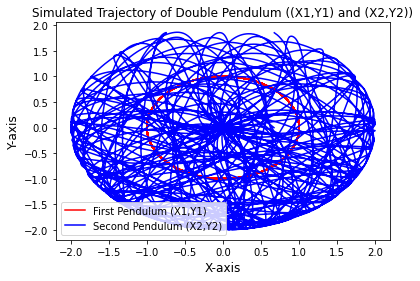

In [ ]:
plt.figure()
plt.title('Simulated Trajectory of Double Pendulum ((X1,Y1) and (X2,Y2))')
plt.xlabel('X-axis', fontsize=12)
plt.ylabel('Y-axis', fontsize=12)
plt.plot(L1*sin(z1), -L1*cos(z1),label='First Pendulum (X1,Y1)' ,color="RED")
plt.plot(L2*sin(z2)+L1*sin(z1), -L2*cos(z2)-L2*cos(z1),label='Second Pendulum (X2,Y2)' ,color="BLUE")
plt.legend()
# plt.plot(z2_dot+sin(data[:,3][8100:10000]),-cos(data[:,1][8100:10000])-cos(data[:,3][8100:10000]),color="blue")

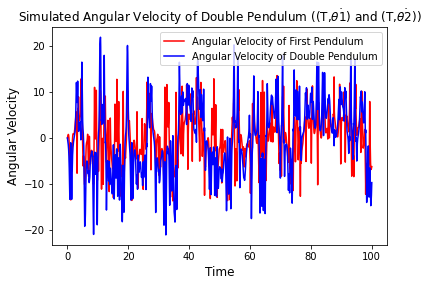

In [ ]:
plt.figure()
plt.title('Simulated Angular Velocity of Double Pendulum ((T,$\\dot{\\theta1}$) and (T,$\\dot{\\theta2}$))')
plt.xlabel('Time', fontsize=12)
plt.ylabel('Angular Velocity', fontsize=12)
plt.plot(t,z1_dot,label='Angular Velocity of First Pendulum' ,color="RED")
plt.plot(t,z2_dot+z1_dot,label='Angular Velocity of Double Pendulum' ,color="blue")
plt.legend()

In [ ]:
import csv
with open('/content/drive/MyDrive/CS504 project/Hamiltonian-chaotic.csv', 'w', newline='') as file:
    fieldnames = ['Time', 'Z1','Z1_dot','Z2','Z2_dot']
    writer = csv.DictWriter(file, fieldnames=fieldnames)
    writer.writerow({'Time': "Time", 'Z1':"Z1",'Z1_dot': "Z1_dot",'Z2':"Z2",'Z2_dot':"Z2_dot"})
    for i in range(0,len(t)):
        writer.writerow({'Time': t[i], 'Z1':z1[i],'Z1_dot': z1_dot[i],'Z2':z2[i],'Z2_dot':z2_dot[i]})

##Data process

In [ ]:
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from keras.preprocessing.sequence import TimeseriesGenerator
from sklearn.preprocessing import MinMaxScaler, StandardScaler
import tensorflow as tf


In [ ]:
df = pd.read_csv('/content/drive/MyDrive/CS504 project/Hamiltonian-chaotic.csv')

In [ ]:
df

,Time,Z1,Z1_dot,Z2,Z2_dot
0,0.00,2.967060,0.001745,2.617994,0.001745
1,0.01,2.967243,0.035008,2.617610,-0.078519
2,0.02,2.967760,0.068302,2.616423,-0.158857
3,0.03,2.968610,0.101651,2.614432,-0.239340
4,0.04,2.969793,0.135076,2.611636,-0.320034
...,...,...,...,...,...
9995,99.95,-3.233267,-6.395431,-24.636787,-4.391167
9996,99.96,-3.297035,-6.357806,-24.679630,-4.175931
9997,99.97,-3.360417,-6.318187,-24.720275,-3.951438
9998,99.98,-3.423393,-6.276744,-24.758629,-3.717895


In [ ]:
df_input=df[['Time', 'Z1','Z1_dot','Z2','Z2_dot']]
df_input

,Time,Z1,Z1_dot,Z2,Z2_dot
0,0.00,2.967060,0.001745,2.617994,0.001745
1,0.01,2.967243,0.035008,2.617610,-0.078519
2,0.02,2.967760,0.068302,2.616423,-0.158857
3,0.03,2.968610,0.101651,2.614432,-0.239340
4,0.04,2.969793,0.135076,2.611636,-0.320034
...,...,...,...,...,...
9995,99.95,-3.233267,-6.395431,-24.636787,-4.391167
9996,99.96,-3.297035,-6.357806,-24.679630,-4.175931
9997,99.97,-3.360417,-6.318187,-24.720275,-3.951438
9998,99.98,-3.423393,-6.276744,-24.758629,-3.717895


In [ ]:
with open('/content/drive/MyDrive/CS504 project/Hamiltonian-chaotic.csv', 'r') as f:
    reader = csv.reader(f, delimiter=',')
    headers = next(reader)
    data = np.array(list(reader)).astype(float)
print(headers)
print(data.shape)
print(data)

['Time', 'Z1', 'Z1_dot', 'Z2', 'Z2_dot']
(10000, 5)
[[ 0.00000000e+00  2.96705973e+00  1.74532925e-03  2.61799388e+00
   1.74532925e-03]
 [ 1.00000000e-02  2.96724348e+00  3.50081703e-02  2.61761004e+00
  -7.85185119e-02]
 [ 2.00000000e-02  2.96775999e+00  6.83017460e-02  2.61642326e+00
  -1.58856876e-01]
 ...
 [ 9.99700000e+01 -3.36041692e+00 -6.31818724e+00 -2.47202748e+01
  -3.95143793e+00]
 [ 9.99800000e+01 -3.42339299e+00 -6.27674419e+00 -2.47586289e+01
  -3.71789490e+00]
 [ 9.99900000e+01 -3.48594668e+00 -6.23377087e+00 -2.47946037e+01
  -3.47565711e+00]]


In [ ]:
data[:,0][8001:10001]

array([80.01, 80.02, 80.03, ..., 99.97, 99.98, 99.99])

In [ ]:
data[:,1][8001:10001]

array([-44.59696826, -44.58462784, -44.57576825, ...,  -3.36041692,
        -3.42339299,  -3.48594668])

In [ ]:
df_input.describe()

,Time,Z1,Z1_dot,Z2,Z2_dot
count,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000
mean,49.995000,-26.347221,-0.064842,-52.425674,-0.274297
std,28.868957,18.066836,4.950718,27.578978,5.890599
min,0.000000,-52.925920,-13.696809,-96.635037,-16.731387
25%,24.997500,-43.198019,-3.909710,-78.347136,-4.965248
50%,49.995000,-27.538649,0.159137,-57.107121,-0.562307
75%,74.992500,-11.023707,3.673941,-31.178333,4.487751
max,99.990000,8.968844,13.752907,3.143048,16.698491


In [ ]:
scaler = MinMaxScaler()
data_scaled = scaler.fit_transform(df_input)

In [ ]:
data_scaled

array([[0.00000000e+00, 9.03032436e-01, 4.99041739e-01, 9.94737779e-01,
        5.00544222e-01],
       [1.00010001e-04, 9.03035404e-01, 5.00253513e-01, 9.94733932e-01,
        4.98143261e-01],
       [2.00020002e-04, 9.03043749e-01, 5.01466406e-01, 9.94722038e-01,
        4.95740071e-01],
       ...,
       [9.99799980e-01, 8.00802841e-01, 2.68805018e-01, 7.20747067e-01,
        3.82291227e-01],
       [9.99899990e-01, 7.99785371e-01, 2.70314799e-01, 7.20362673e-01,
        3.89277284e-01],
       [1.00000000e+00, 7.98774725e-01, 2.71880328e-01, 7.20002125e-01,
        3.96523430e-01]])

In [ ]:
features=data_scaled
target=data_scaled

In [ ]:
x_train=features[0:8000]
y_train=target[0:8000]
x_test=features[8000:10000]
y_test=target[8000:10000]

In [ ]:
win_length=200
batch_size=1
num_features=5
train_generator = TimeseriesGenerator(x_train, y_train, length=win_length, sampling_rate=1, batch_size=batch_size)
test_generator = TimeseriesGenerator(x_test, y_test, length=win_length, sampling_rate=1, batch_size=batch_size)

In [ ]:
X=np.array(([train_generator[0][0][0,:]]))
Y1=np.array(np.vstack((train_generator[0][1][:,0])))
Y2=np.array(np.vstack((train_generator[0][1][:,1])))
Y3=np.array(np.vstack((train_generator[0][1][:,2])))
Y4=np.array(np.vstack((train_generator[0][1][:,3])))
Y5=np.array(np.vstack((train_generator[0][1][:,4])))

for i in range(1,7800):
    X=np.vstack((X,[train_generator[i][0][0,:]]))
    Y1=np.vstack((Y1,train_generator[i][1][:,0]))
    Y2=np.vstack((Y2,train_generator[i][1][:,1]))
    Y3=np.vstack((Y3,train_generator[i][1][:,2]))
    Y4=np.vstack((Y4,train_generator[i][1][:,3]))
    Y5=np.vstack((Y5,train_generator[i][1][:,4]))

In [ ]:
win_length=200
batch_size=1
num_features=5
title_input = keras.Input(shape= (win_length, num_features), name="title_input") 
title_features = layers.Dense(5)(title_input)

LSTM1 = layers.LSTM(30, return_sequences=True,input_shape= (win_length, num_features))(title_features)
LSTM2 = layers.LSTM(30, return_sequences=True,input_shape= (win_length, num_features))(title_features)
LSTM3 = layers.LSTM(30, return_sequences=True,input_shape= (win_length, num_features))(title_features)
LSTM4 = layers.LSTM(30, return_sequences=True,input_shape= (win_length, num_features))(title_features)
LSTM5 = layers.LSTM(30, return_sequences=True,input_shape= (win_length, num_features))(title_features)

LSTM6 = layers.LSTM(30, input_shape= (win_length, num_features))(LSTM1)
LSTM7 = layers.LSTM(30, input_shape= (win_length, num_features))(LSTM2)
LSTM8 = layers.LSTM(30, input_shape= (win_length, num_features))(LSTM3)
LSTM9 = layers.LSTM(30, input_shape= (win_length, num_features))(LSTM4)
LSTM10 = layers.LSTM(30, input_shape= (win_length, num_features))(LSTM5)

out1=layers.Dense(1,name="out1")(LSTM6)
out2=layers.Dense(1,name="out2")(LSTM7)
out3=layers.Dense(1,name="out3")(LSTM8)
out4=layers.Dense(1,name="out4")(LSTM9)
out5=layers.Dense(1,name="out5")(LSTM10)

model = keras.Model(
    inputs=[title_input],
    outputs=[out1, out2,out3,out4,out5],
)

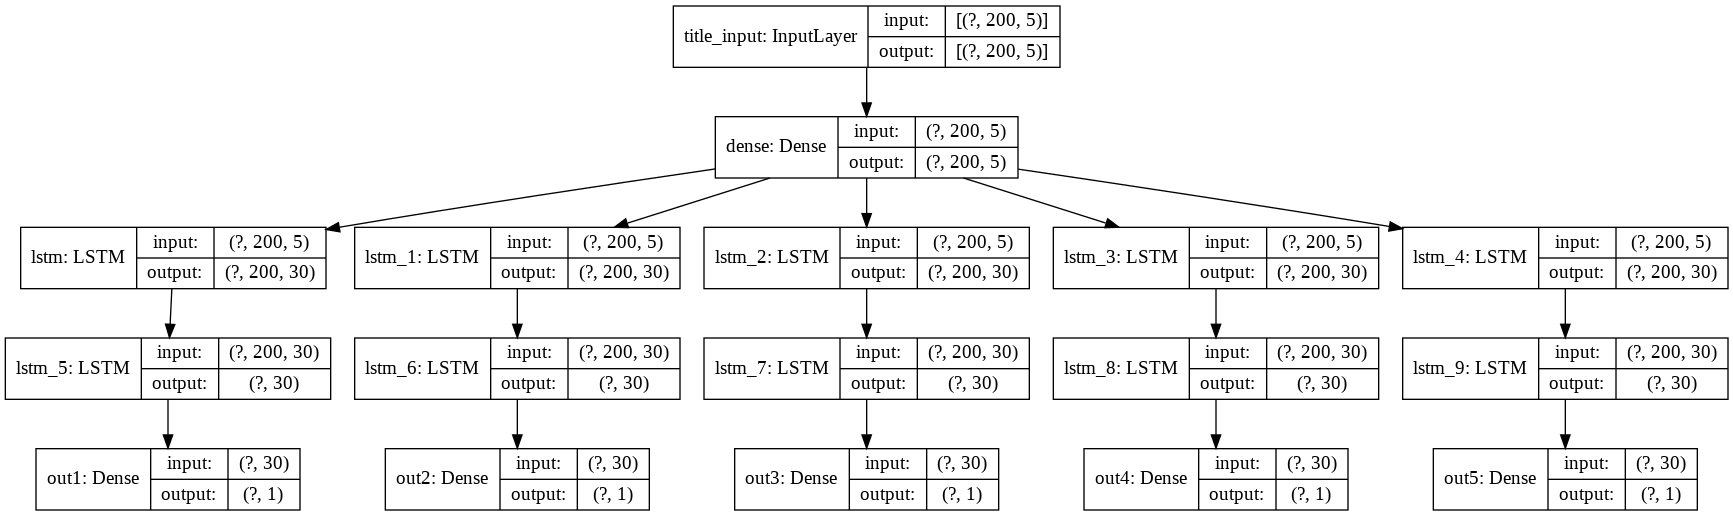

In [ ]:
keras.utils.plot_model(model, show_shapes=True)

In [ ]:
model.compile(loss=tf.losses.MeanSquaredError(),optimizer=tf.optimizers.Adam(),metrics=[tf.metrics.MeanAbsoluteError()])

history = model.fit(    {"title_input": X},
    {"out1": Y1, "out2": Y2, "out3": Y3, "out4": Y4, "out5": Y5,}, 
    epochs=30, validation_batch_size=0.1,
    shuffle=False)

Epoch 1/30
244/244 [==============================] - 125s 512ms/step - loss: 0.0807 - out1_loss: 0.0016 - out2_loss: 0.0201 - out3_loss: 0.0233 - out4_loss: 0.0178 - out5_loss: 0.0178 - out1_mean_absolute_error: 0.0298 - out2_mean_absolute_error: 0.0963 - out3_mean_absolute_error: 0.0976 - out4_mean_absolute_error: 0.0835 - out5_mean_absolute_error: 0.0919
Epoch 2/30
244/244 [==============================] - 126s 516ms/step - loss: 0.0431 - out1_loss: 0.0069 - out2_loss: 0.0154 - out3_loss: 0.0043 - out4_loss: 0.0117 - out5_loss: 0.0048 - out1_mean_absolute_error: 0.0376 - out2_mean_absolute_error: 0.0842 - out3_mean_absolute_error: 0.0484 - out4_mean_absolute_error: 0.0742 - out5_mean_absolute_error: 0.0516
Epoch 3/30
244/244 [==============================] - 126s 515ms/step - loss: 0.0422 - out1_loss: 0.0122 - out2_loss: 0.0094 - out3_loss: 0.0029 - out4_loss: 0.0139 - out5_loss: 0.0038 - out1_mean_absolute_error: 0.0413 - out2_mean_absolute_error: 0.0697 - out3_mean_absolute_erro

In [ ]:
model.evaluate_generator(test_generator, verbose=2)  
o1,o2,o3,o4,o5=model.predict_generator(test_generator)

Instructions for updating:
Please use Model.evaluate, which supports generators.
1800/1800 - 81s - loss: 0.4543 - out1_loss: 0.0498 - out2_loss: 0.0859 - out3_loss: 0.1722 - out4_loss: 0.0369 - out5_loss: 0.1094 - out1_mean_absolute_error: 0.1856 - out2_mean_absolute_error: 0.2503 - out3_mean_absolute_error: 0.3393 - out4_mean_absolute_error: 0.1497 - out5_mean_absolute_error: 0.2623
Instructions for updating:
Please use Model.predict, which supports generators.


In [ ]:
testX=np.array(([test_generator[0][0][0,:]]))
testY1=np.array(np.vstack((test_generator[0][1][:,0])))
testY2=np.array(np.vstack((test_generator[0][1][:,1])))
testY3=np.array(np.vstack((test_generator[0][1][:,2])))
testY4=np.array(np.vstack((test_generator[0][1][:,3])))
testY5=np.array(np.vstack((test_generator[0][1][:,4])))

for i in range(1,1799):
    testX=np.vstack((X,[test_generator[i][0][0,:]]))
    testY1=np.vstack((Y1,test_generator[i][1][:,0]))
    testY2=np.vstack((Y2,test_generator[i][1][:,1]))
    testY3=np.vstack((Y3,test_generator[i][1][:,2]))
    testY4=np.vstack((Y4,test_generator[i][1][:,3]))
    testY5=np.vstack((Y5,test_generator[i][1][:,4]))

In [ ]:
df_pred=pd.concat([pd.DataFrame(o1), pd.DataFrame(o2),pd.DataFrame(o3),pd.DataFrame(o4),pd.DataFrame(o5)],axis=1)

In [ ]:
df_pred

,0,0,0,0,0
0,0.799233,0.192388,0.640017,0.459952,0.765203
1,0.799375,0.194021,0.623803,0.460709,0.765251
2,0.799618,0.195517,0.606401,0.461474,0.764281
3,0.799956,0.196858,0.588065,0.462249,0.762484
4,0.800378,0.198024,0.569055,0.463035,0.760082
...,...,...,...,...,...
1795,0.669432,0.472337,0.062399,0.661611,0.292833
1796,0.670606,0.472329,0.063739,0.661633,0.297662
1797,0.671820,0.472342,0.065143,0.661675,0.302732
1798,0.673074,0.472376,0.066607,0.661738,0.308042


In [ ]:
rev_trans=scaler.inverse_transform(df_pred)
rev_trans

array([[ 79.915306 , -41.0181   ,   3.8714805, -50.741905 ,   8.849248 ],
       [ 79.92949  , -40.917053 ,   3.4264202, -50.66633  ,   8.850861 ],
       [ 79.95377  , -40.82443  ,   2.9487324, -50.590015 ,   8.818443 ],
       ...,
       [ 67.17528  , -23.690434 , -11.90865  , -30.614386 ,  -6.6110835],
       [ 67.30071  , -23.688314 , -11.868453 , -30.608046 ,  -6.433573 ],
       [ 67.43039  , -23.68483  , -11.826769 , -30.599459 ,  -6.248228 ]],
      dtype=float32)

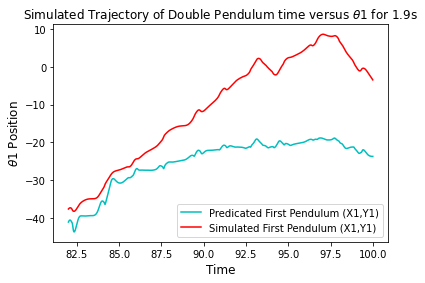

In [ ]:
plt.figure()
plt.xlabel('Time', fontsize=12)
plt.ylabel('$\\theta1$ Position', fontsize=12)
plt.title('Simulated Trajectory of Double Pendulum time versus $\\theta1$ for 1.9s')
plt.plot(data[:,0][8200:10000], rev_trans[:,1],label='Predicated First Pendulum (X1,Y1)' ,color="c")
plt.plot(data[:,0][8200:10000],data[:,1][8200:10000],label='Simulated First Pendulum (X1,Y1)' ,color="red")
plt.legend()

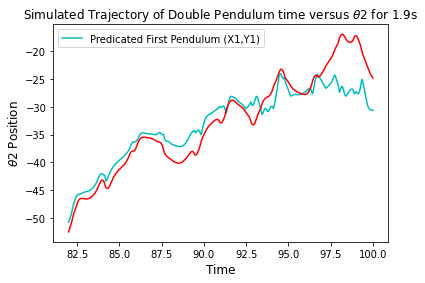

In [ ]:
plt.figure()
plt.xlabel('Time', fontsize=12)
plt.ylabel('$\\theta2$ Position', fontsize=12)
plt.title('Simulated Trajectory of Double Pendulum time versus $\\theta2$ for 1.9s')
plt.plot(data[:,0][8200:10000], rev_trans[:,3],label='Predicated First Pendulum (X1,Y1)' ,color="c")
plt.plot(data[:,0][8200:10000],data[:,3][8200:10000],color="red")
plt.legend()

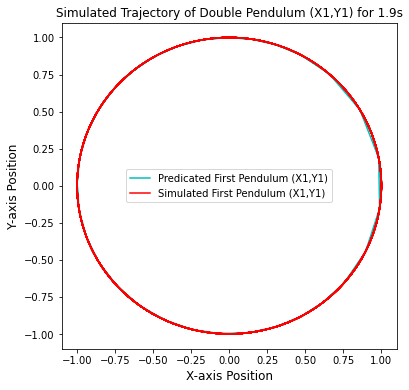

In [ ]:
plt.figure(figsize=(6,6))
plt.xlabel('X-axis Position', fontsize=12)
plt.ylabel('Y-axis Position', fontsize=12)
plt.title('Simulated Trajectory of Double Pendulum (X1,Y1) for 1.9s')
plt.plot(L1*sin(rev_trans[:,1]), -L1*cos(rev_trans[:,1]),label='Predicated First Pendulum (X1,Y1)' ,color="c")
plt.plot(L1*sin(data[:,1][8200:10000]), -L1*cos(data[:,1][8200:10000]),label='Simulated First Pendulum (X1,Y1)' ,color="RED")
plt.legend()

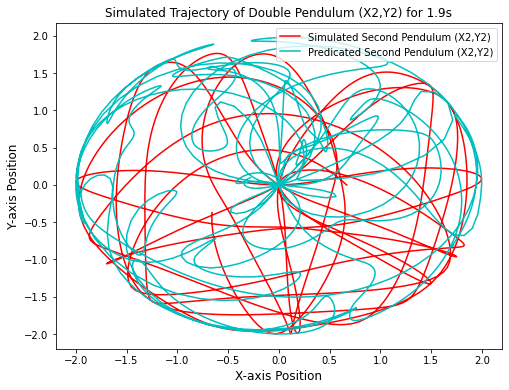

In [ ]:
plt.figure(figsize=(8,6))
plt.xlabel('X-axis Position', fontsize=12)
plt.ylabel('Y-axis Position', fontsize=12)
plt.title('Simulated Trajectory of Double Pendulum (X2,Y2) for 1.9s')
plt.plot(L2*sin(data[:,3][8200:10000])+L1*sin(data[:,1][8200:10000]), -L2*cos(data[:,3][8200:10000])-L2*cos(data[:,1][8200:10000]),label='Simulated Second Pendulum (X2,Y2)' ,color="RED")
plt.plot(L2*sin(rev_trans[:,3])+L1*sin(rev_trans[:,1]), -L2*cos(rev_trans[:,3])-L2*cos(rev_trans[:,1]),label='Predicated Second Pendulum (X2,Y2)' ,color="c")
plt.legend()

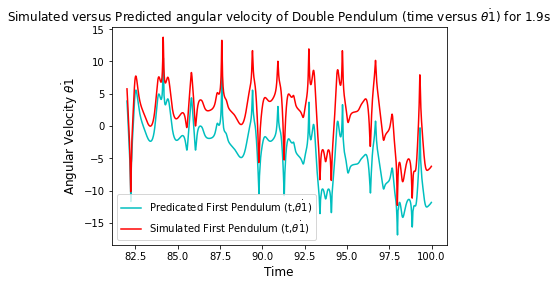

In [ ]:
plt.figure()
plt.xlabel('Time', fontsize=12)
plt.ylabel('Angular Velocity $\\dot{\\theta1}$', fontsize=12)
plt.title('Simulated versus Predicted angular velocity of Double Pendulum (time versus $\\dot{\\theta1}$) for 1.9s')
plt.plot(data[:,0][8200:10000], rev_trans[:,2],label='Predicated First Pendulum (t,$\\dot{\\theta1}$)' ,color="c")
plt.plot(data[:,0][8200:10000],data[:,2][8200:10000],label='Simulated First Pendulum (t,$\\dot{\\theta1}$)' ,color="red")
plt.legend()

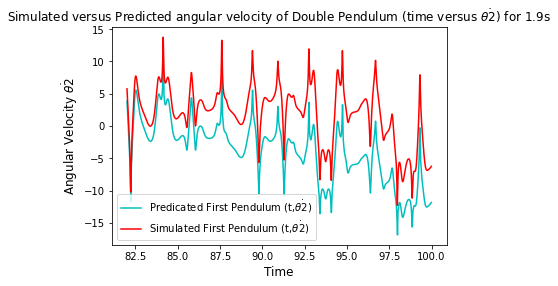

In [ ]:
plt.figure()
plt.xlabel('Time', fontsize=12)
plt.ylabel('Angular Velocity $\\dot{\\theta2}$', fontsize=12)
plt.title('Simulated versus Predicted angular velocity of Double Pendulum (time versus $\\dot{\\theta2}$) for 1.9s')
plt.plot(data[:,0][8200:10000], rev_trans[:,2],label='Predicated First Pendulum (t,$\\dot{\\theta2}$)' ,color="c")
plt.plot(data[:,0][8200:10000],data[:,2][8200:10000],label='Simulated First Pendulum (t,$\\dot{\\theta2}$)' ,color="red")
plt.legend()